In [16]:
import numpy as np
import pandas as pd 
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [17]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [84]:
path = "/Users/mgmanuel/train/"
filenames = os.listdir(path) 
  
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [77]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [79]:
df.tail()

,filename,category
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1
25000,train.zip,0


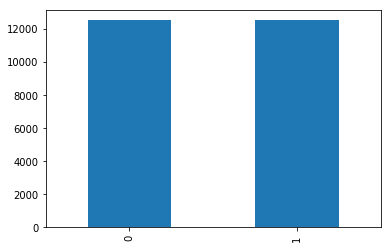

In [80]:
df['category'].value_counts().plot.bar()

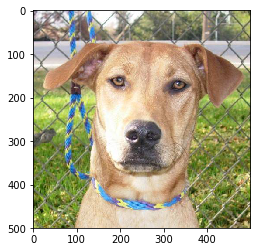

In [85]:
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
____

In [87]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [88]:
earlystop = EarlyStopping(patience=10)

In [89]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [90]:
callbacks = [earlystop, learning_rate_reduction]

In [91]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [92]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

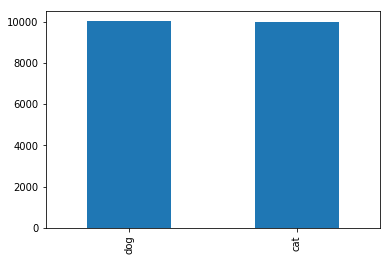

In [93]:
train_df['category'].value_counts().plot.bar()

In [94]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [95]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19999 validated image filenames belonging to 2 classes.


In [96]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5001 validated image filenames belonging to 2 classes.


In [97]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


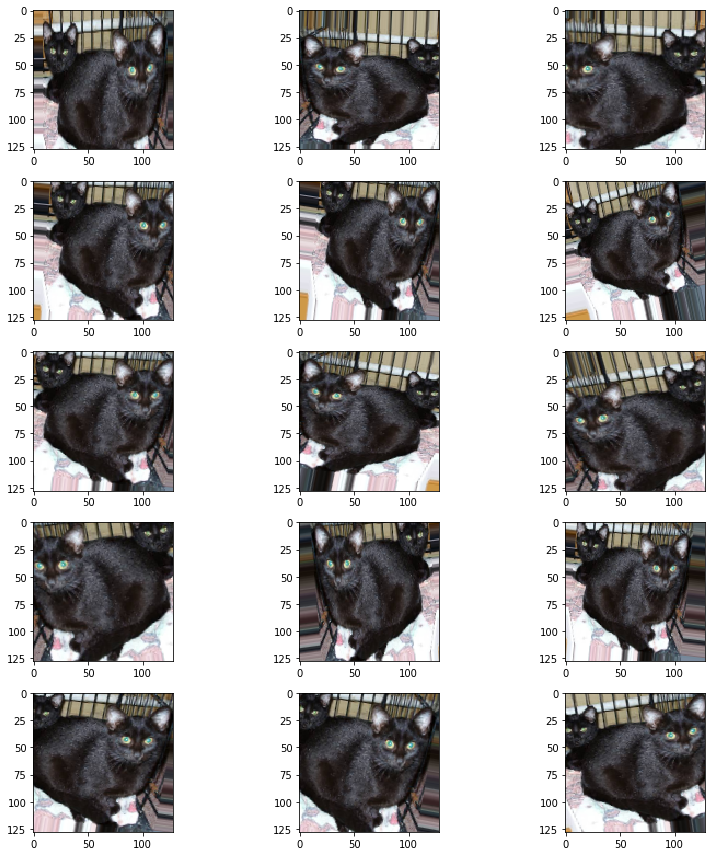

In [98]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [100]:
epochs=15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/15
1333/1333 [==============================] - 1345s 1s/step - loss: 0.5150 - acc: 0.7530 - val_loss: 0.5756 - val_acc: 0.6945
Epoch 2/15
1333/1333 [==============================] - 1314s 986ms/step - loss: 0.4758 - acc: 0.7773 - val_loss: 0.4842 - val_acc: 0.8008
Epoch 3/15
1333/1333 [==============================] - 1283s 962ms/step - loss: 0.4487 - acc: 0.7945 - val_loss: 1.0691 - val_acc: 0.6969
Epoch 4/15
1333/1333 [==============================] - 1273s 955ms/step - loss: 0.4247 - acc: 0.8092 - val_loss: 0.3612 - val_acc: 0.8434
Epoch 5/15
1333/1333 [==============================] - 1118s 839ms/step - loss: 0.4073 - acc: 0.8194 - val_loss: 0.3608 - val_acc: 0.8408
Epoch 6/15
1332/1333 [============================>.] - ETA: 0s - loss: 0.3898 - acc: 0.8300
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 1160s 870ms/step - loss: 0.3898 - acc: 0.8301 - val_loss: 0.4816 - val_acc: 0.7936
Epoch 7

In [101]:
model.save_weights("model.h5")

In [102]:
path1 = "/Users/mgmanuel/test1/"
test_filenames = os.listdir(path1)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [103]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path1, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 3855 validated image filenames.


In [105]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [106]:
test_df['category'] = np.argmax(predict, axis=-1)

In [107]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

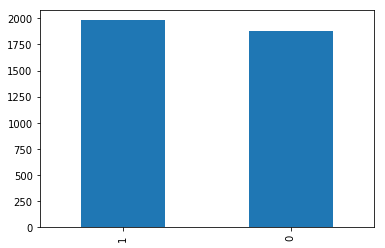

In [109]:
test_df['category'].value_counts().plot.bar()

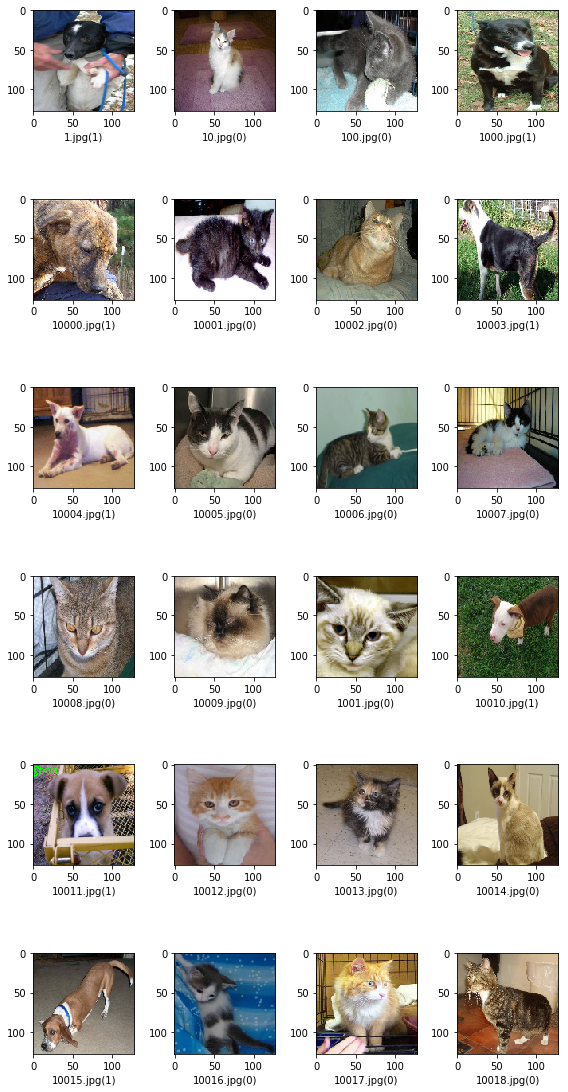

In [117]:
sample_test = test_df.head(24)
sample_test.head()
plt.figure(figsize=(8, 16))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(path1+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 4, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()